In [2]:
from google.colab import drive
drive.mount("/content/drive")

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import spacy

from sklearn.feature_extraction.text import CountVectorizer , TfidfVectorizer, HashingVectorizer

from wordcloud import WordCloud


%matplotlib inline 

import torch
import torch.nn as nn


Mounted at /content/drive


In [3]:
traindf = pd.read_csv("/content/drive/MyDrive/Colab_Notebooks/ΑΙ_2/prj1/vs_train.csv")
valdf = pd.read_csv("/content/drive/MyDrive/Colab_Notebooks/ΑΙ_2/prj1/vs_dev.csv")

truedf = traindf[traindf['label']==2]
falsedf = traindf[traindf['label']==1]
neutraldf = traindf[traindf['label']==0]


###Preprocessing tweets with spacy

In [4]:
nlp = spacy.load("en_core_web_sm")
stopSet = {'.', ',', '-', '!', '$', '%', '^','&','*','(',')','_','+','=','\'','\"',':','—', '#', '@'}
traindf_list = []
def lemmatization(column):
  count=0
  lemmatized = []
  for x in column:
    spaced = nlp(x)
    lemmastr = ""
    for token in spaced:
      token.lemma_ = token.lemma_.lower()
      if token.is_stop == False and not token.lemma_ in stopSet:
        lemmastr += str(token.lemma_+' ')
    lemmatized.append(lemmastr)
    count+=1
    if(count >1000):
      count = 0
      print(count)
  return lemmatized


### Vectorizers and curves functions

In [5]:
import urllib.request
urllib.request.urlretrieve('https://nlp.stanford.edu/data/glove.twitter.27B.zip','glove.twitter.27B.zip')

!unzip "/content/glove.twitter.27B.zip" -d "/content/"

Archive:  /content/glove.twitter.27B.zip
  inflating: /content/glove.twitter.27B.25d.txt  
  inflating: /content/glove.twitter.27B.50d.txt  
  inflating: /content/glove.twitter.27B.100d.txt  
  inflating: /content/glove.twitter.27B.200d.txt  


In [6]:
emmbed_dict = {}
with open('/content/glove.twitter.27B.200d.txt','r') as f:
  for line in f:
    values = line.split()
    word = values[0]
    vector = np.asarray(values[1:],'float32')
    emmbed_dict[word]=vector

In [ ]:
train_list = lemmatization(traindf.tweet)
train = pd.DataFrame( list(zip(train_list, traindf.label)) , columns = ['tweet', 'label'])

test_list = lemmatization(valdf.tweet)
test = pd.DataFrame( list(zip(test_list, valdf.label)) , columns = ['tweet', 'label'])


In [73]:
from sklearn.metrics import accuracy_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, RepeatedStratifiedKFold
from sklearn.model_selection import learning_curve
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report

stopWordsList = ['that','it','are','in','as','this','the','with','they','their','and','an','a','at','to','for','by','his','her','is','for','of','in','from','him','on','http','https','co','you']


# bag of words vectorizer
def bow_fun(rrange,maxf):
  bow_vectorizer = CountVectorizer(max_df=0.80, min_df=1, max_features=maxf,ngram_range=rrange,stop_words=stopWordsList, lowercase=False)
  return bow_vectorizer;


def GloVe_fun(corpus):
  x = list()
  wlist = corpus.apply(lambda x: x.split()).values 
  #print(wlist)
  for phrase in wlist:                        # for every tweet
    phrase_list_vect = []
    for word in phrase:                       # for every word in that tweet
      if word in emmbed_dict:                 # if word exists in GloVe pre-trained dictionary
        phrase_list_vect += [emmbed_dict[word].tolist()]  # append the vector with its values to a list
    if(len(phrase_list_vect) == 0):
      x.append(np.array(np.zeros(200), dtype='f'))
      #continue
    else:
      phrase_arr_vect = np.array(phrase_list_vect,dtype='f') # convert list to numpy array for faster computations
      x.append(np.mean(phrase_arr_vect, axis=0))

  x_arr = np.array(x)
  return x_arr


# function to compute learning curve and plot
def learning_curves(x_train, y_train, x_test, y_test, title_input):
  
  plt.plot(x_train, y_train, label = 'Training loss', linestyle = '-', marker='o')
  plt.plot(x_test, y_test, label = 'Validation loss',linestyle = '-', marker='o')

  #some visual add-ons
  plt.grid()
  plt.ylabel('loss', fontsize = 10)
  plt.xlabel('epoch', fontsize = 10)
  title = title_input
  plt.title(title, fontsize = 14, y = 1.03)
  plt.legend()
  plt.ylim(0,1)
  plt.yticks(np.arange(0.0,1.0, 0.1))

def plot_roc_curve(fpr, tpr, roc_auc):
  lw = 2
  colors = cycle(["aqua", "darkorange", "cornflowerblue"])
  for i, color in zip(range(3), colors):
      plt.plot(
          fpr[i],
          tpr[i],
          color=color,
          lw=lw,
          label="ROC curve of class {0} (area = {1:0.2f})".format(i, roc_auc[i]),
      )
  plt.plot([0.5,1], [0.5,1], color="gray", linestyle='dashed')
  plt.plot([0, 1], [0, 1], "k--", lw=lw)
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel("False Positive Rate")
  plt.ylabel("True Positive Rate")
  plt.title("Some extension of Receiver operating characteristic to multiclass")
  plt.legend(loc="lower right")
  plt.show()


In [75]:
from sklearn.metrics import roc_curve, auc
from itertools import cycle

#########################################
######   CLASSIFICATION FUNCTION   ######
class NeuralNet(nn.Module):
  def __init__(self, D_in, H, D_out):
    super(NeuralNet, self).__init__()

    self.linear1 = nn.Linear(D_in, H[0])
    self.linear2 = nn.Linear(H[0], H[1])
    #self.linear3 = nn.Linear(H[1], H[2])
    self.linear4 = nn.Linear(H[1], D_out)

    self.activ_fun = nn.LeakyReLU()
    self.out_activ_fun = nn.Softmax(dim=1)
    
  def forward(self, x):
    h1 = self.activ_fun(self.linear1(x))
    h2 = self.activ_fun(self.linear2(h1))
    #h3 = self.activ_fun(self.linear3(h2))
    out = self.linear4(h2)
    return out

def training_loop(dataloader,net, loss_fun, optimizer):
  batch_losses = 0
  for x_batch, y_batch in dataloader:
    y_pred = net(x_batch)
    
    loss = loss_fun(y_pred, y_batch)
    batch_losses += loss.item()
    #Delete previously stored gradients
    optimizer.zero_grad()
    #Perform backpropagation starting from the loss calculated in this epoch
    loss.backward()
    #Update net's weights based on the gradients calculated during backprop
    optimizer.step()

  return batch_losses

def validation_loop(dataloader,net, loss_fun, printROC):
  y_pred_total = []
  y_label_total = []
  batch_losses = 0
  with torch.no_grad():
    for x_batch, y_batch in dataloader:
      y_pred = net(x_batch)
      y_pred_softmax = net.out_activ_fun(y_pred)

      loss = loss_fun(y_pred, y_batch)
      #y_pred_total += y_pred.argmax(1).type(torch.long).tolist()
      batch_losses += loss.item()
      if printROC:
        y_label_total += y_batch.tolist()
        y_pred_total += y_pred_softmax.tolist()

  return batch_losses, y_pred_total, y_label_total


def nn_loop(x_train, y_train, x_test, y_test, net, loss_fun, optimizer, epochs):
  x = torch.tensor(x_train, dtype=torch.float)
  y = torch.tensor(y_train, dtype=torch.long)
  #Initialize dataloader
  dataset = torch.utils.data.TensorDataset(x, y)

  dataloader_train = torch.utils.data.DataLoader(dataset, batch_size=4000, shuffle=True)

  x = torch.tensor(x_test, dtype=torch.float)
  y = torch.tensor(y_test, dtype=torch.long)
  #Initialize dataloader
  dataset = torch.utils.data.TensorDataset(x, y)
  dataloader_test = torch.utils.data.DataLoader(dataset, batch_size=500, shuffle=True)

  data_train_len = len(dataloader_train)
  data_test_len = len(dataloader_test)
  batch_losses_train = []
  batch_losses_test = []
  patience = 3
  last_loss = 10000
  ########### epoch loop ##########
  for epoch in range(epochs):
    ## training loop
    batch_loss_train = training_loop(dataloader_train, net, loss_fun, optimizer)
    batch_losses_train += [ batch_loss_train / data_train_len]

    ## validation loop
    batch_loss_test, y_pred_test, y_label_test = validation_loop(dataloader_test, net, loss_fun, (epoch == epochs-1) )
    batch_losses_test += [batch_loss_test / data_test_len]

    # implement early stopping, if validation loss is rising 'patience' times in a row
    if batch_loss_test > last_loss:
      trigger_times += 1
      if trigger_times >= patience:
        break
    else:
      trigger_times = 0

    last_loss = batch_loss_test


  y_pred_arr = np.array([np.array(xi) for xi in y_pred_test])
  y_test_arr = np.array(y_label_test)

  y_test_roc = np.zeros((y_test_arr.size, np.max(y_test_arr)+1))
  y_test_roc[np.arange(y_test_arr.size),y_test_arr] = 1

  fpr = dict()
  tpr = dict()
  roc_auc = dict()
  n_classes = y_pred_arr.shape[1]
  for i in range(n_classes):
      fpr[i], tpr[i], _ = roc_curve(y_test_roc[:, i], y_pred_arr[:, i])
      roc_auc[i] = auc(fpr[i], tpr[i])

  # First aggregate all false positive rates
  all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

  # Then interpolate all ROC curves at this points
  mean_tpr = np.zeros_like(all_fpr)
  for i in range(n_classes):
      mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

  # Finally average it and compute AUC
  mean_tpr /= n_classes

  fpr["macro"] = all_fpr
  tpr["macro"] = mean_tpr
  roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

  y_pred = [x.index(max(x)) for x in y_pred_test]
  y_label = y_label_test

  return batch_losses_train, batch_losses_test, y_pred, y_label, fpr, tpr, roc_auc

  



def classify(traindf,testdf):
  plt.figure(figsize = (16,10))

  k = 0
  for vectorizer in [("bow"),("glove")]:
    # here declare parameters for vectorization and classification model
    if vectorizer == "bow":
      vect = bow_fun((1,2),450)
      train_list = traindf['tweet'].tolist()
      test_list = testdf['tweet'].tolist()
      x_train = vect.fit_transform(train_list).todense()
      x_test = vect.transform(test_list).todense()
    elif vectorizer == "glove":
      x_train = GloVe_fun(traindf.tweet)
      x_test = GloVe_fun(testdf.tweet)
    else:
      print("Please give valid vectorizer!")
      return 0;



    # labels
    y_train = np.array( [np.array(label) for label in traindf['label']]).astype(np.long)
    y_test = np.array( [np.array(label) for label in testdf['label']]).astype(np.long)

    #Define layer sizes
    D_in = x_train.shape[1]
    H1 = 256
    H2 = 24
    H3 = 15
    D_out = 3

    #Define Hyperparameters
    #learning_rate = 9e-2   # lr for SGD
    learning_rate = 5e-4    # lr for Adam

    #Initialize net, loss, optimizer
    net = NeuralNet(D_in, [H1, H2, H3], D_out)
    #weights = torch.tensor([0.5,1.0,0.5])  # weights for SGD
    weights = torch.tensor([1.0,1.0,1.0])

    loss_fun = nn.CrossEntropyLoss(weight=weights)
    #optimizer = torch.optim.SGD(net.parameters(), lr=learning_rate)
    optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)

    epochs = 50
    train_batch_losses, test_batch_losses, y_pred, y_label, fpr, tpr, roc_auc = nn_loop(x_train, y_train, x_test, y_test, net, loss_fun, optimizer, epochs)

    x_axis = [i for i in range(epochs)]

    k += 1 
    plt.subplot(2,2,k)
    learning_curves(x_axis, train_batch_losses, x_axis,  test_batch_losses, vectorizer)

    k += 1
    plt.subplot(2,2,k)
    plot_roc_curve(fpr,tpr,roc_auc)
    counter = [(x==1) for x in y_label]
    print(sum(counter))
    print(classification_report(y_label, y_pred, target_names=['Neutral', 'Anti-Vax', 'Pro-Vax']))
    plt.figure(figsize = (16,10))

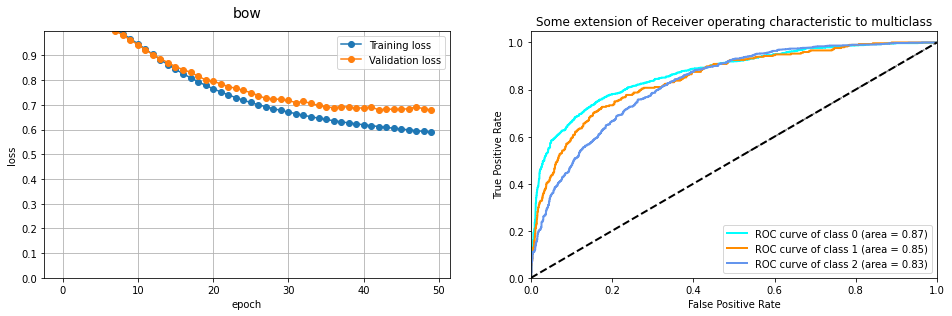

296
              precision    recall  f1-score   support

     Neutral       0.77      0.77      0.77      1065
    Anti-Vax       0.61      0.41      0.49       296
     Pro-Vax       0.66      0.73      0.69       921

    accuracy                           0.71      2282
   macro avg       0.68      0.64      0.65      2282
weighted avg       0.71      0.71      0.70      2282



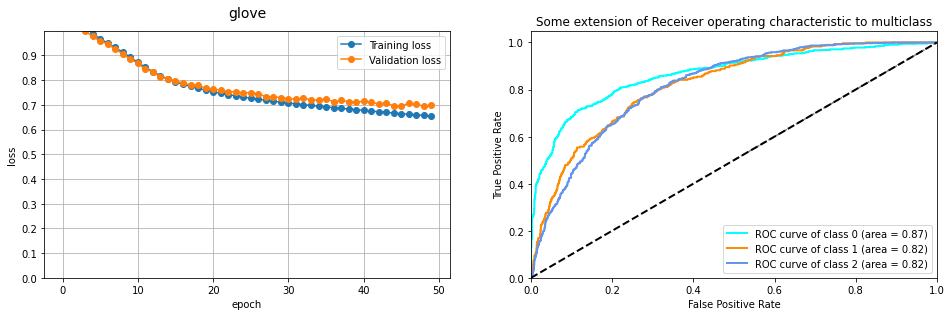

296
              precision    recall  f1-score   support

     Neutral       0.78      0.77      0.77      1065
    Anti-Vax       0.53      0.24      0.33       296
     Pro-Vax       0.64      0.76      0.70       921

    accuracy                           0.70      2282
   macro avg       0.65      0.59      0.60      2282
weighted avg       0.69      0.70      0.68      2282



<Figure size 1152x720 with 0 Axes>

In [76]:
classify(train,test)